# Assignment 4

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [157]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np


image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

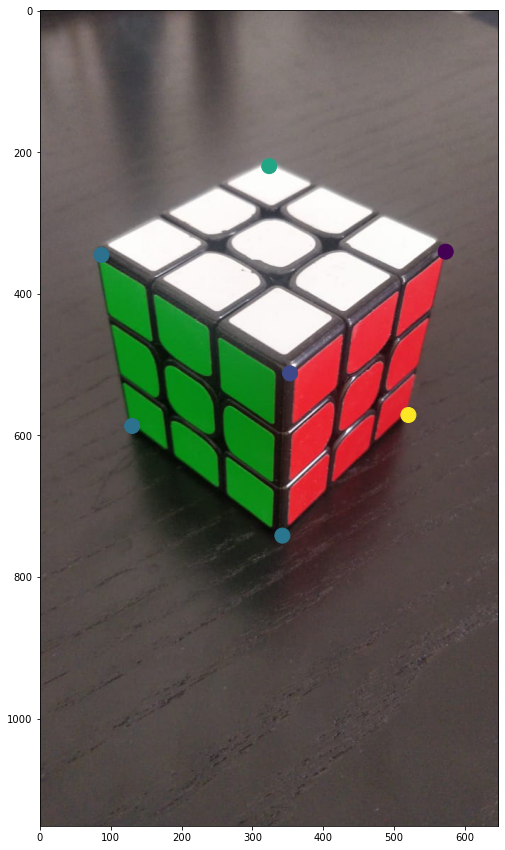

[[ 86.7717593  344.99778172]
 [323.73231427 219.54807615]
 [573.08296362 340.35149633]
 [353.15878842 512.26405582]
 [130.13708962 586.60462209]
 [342.31745584 741.48080181]
 [520.42506252 571.11700411]]


In [159]:
%matplotlib inline
# load from file
image_points = np.load('image_points.npy')
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()
print(image_points)

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [163]:
points = [
    (image_points[0], np.array([4,4,0])),
    (image_points[1], np.array([4,4,4])),
    (image_points[2], np.array([0,4,4])),
    (image_points[3], np.array([0,4,0])),
    (image_points[4], np.array([4,0,0])),
    (image_points[5], np.array([0,0,0])),
    (image_points[6], np.array([0,0,4])),
]

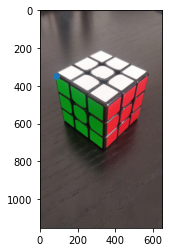

[4 4 0]


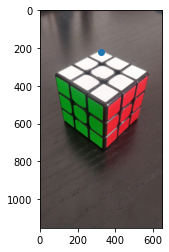

[4 4 4]


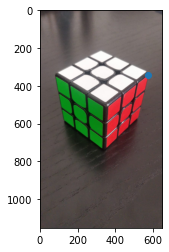

[0 4 4]


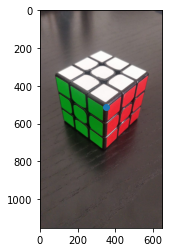

[0 4 0]


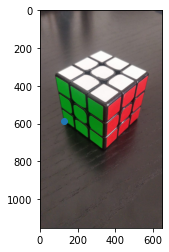

[4 0 0]


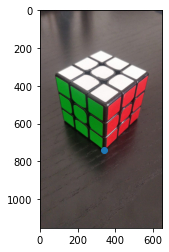

[0 0 0]


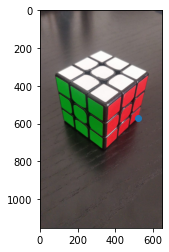

[0 0 4]


In [164]:
for _id in range(7):
    # _id = 1
    plt.imshow(img)
    plt.scatter(image_points[_id,0], image_points[_id,1])
    plt.show()
    print(points[_id][1])

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [165]:
# Creating M matrix
M = []
for (xi,yi), (Xi, Yi, Zi) in points:
    axi = [-Xi, -Yi, -Zi, -1, 0,0,0,0, xi*Xi, xi*Yi, xi*Zi, xi]
    M.append(axi)
    ayi = [0,0,0,0,-Xi, -Yi, -Zi, -1, yi * Xi, yi * Yi, yi * Zi, yi]
    M.append(ayi)
M = np.array(M)
M.shape

(14, 12)

In [166]:
u,s,vh = np.linalg.svd(M)

In [167]:
v_last = vh[-1, :]

In [168]:
P = v_last.reshape(3,4)

In [169]:
point = P @ np.array([*points[0][1], 1])
point[0] /= point[2]
point[1] /= point[2]
# point[:2]
print(points[0][0], point[:2])
np.linalg.norm(points[0][0] - point[:2])

[ 86.7717593  344.99778172] [ 86.28547618 345.75843055]


0.9028055772039842

### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

Done in `dlt.pdf`

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [170]:
x = []
X = []
for xi, Xi in points:
    x.append(xi)
    X.append(Xi)
x = np.array(x)
X = np.array(X)

In [171]:
#Get reprojected points
def get_points(P, X):
    if X.shape[1] == 3:
        X = np.hstack((X, np.ones(X.shape[0]).reshape(-1,1)))
    x = P @ X.T
    x[0] /= x[2]
    x[1] /= x[2]
    return x[:2].T
    

#Get reprojection error
def get_err(x, X, P):
    projected = get_points(P, X)
    err = (np.linalg.norm(x- projected, axis=1)**2).sum()
    return err

In [172]:
print("Reprojection Error is:", get_err(x, X, P))

Reprojection Error is: 2.099539404222431


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [173]:
def ret_RKT(P):
    H = P[:, :3]
    h = P[:, 3].reshape(-1,1)
    H_i = np.linalg.inv(H)
    X0 = -H_i @ h
    Rzpi = np.array([[-1,0,0], [0,-1,0], [0,0,1]])
    q,r = np.linalg.qr(H_i)
    R = Rzpi @ q.T
    K = np.linalg.inv(r)
    K = K @ Rzpi
    T = - R @ X0
    return (R, K, T)

R, K, T = ret_RKT(P)

#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix


In [174]:
P_new = K @ np.hstack((R, T))
np.isclose(P, P_new)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

**Reproject the world points with P matrix you have obtained via DLT and visualize**

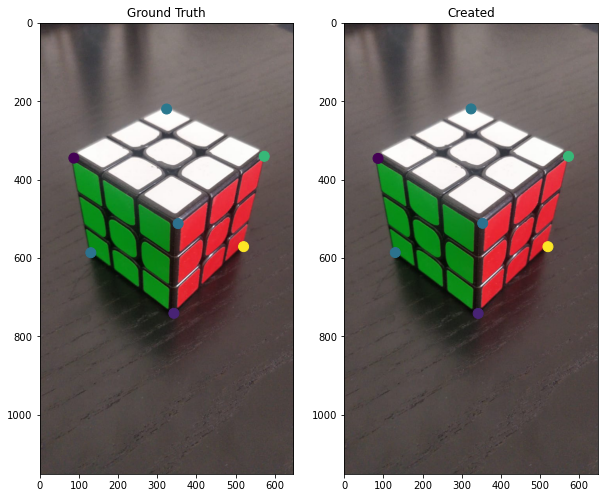

In [175]:
image_points_new = get_points(P, X)

N = len(image_points)
colors = np.random.rand(N)
area = (10 * np.ones(N))**2 
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(10,15))
ax[0].imshow(img)
ax[0].set_title("Ground Truth")
# print("GT")
ax[0].scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
# plt.show()
# print("Created")
# plt.subplot(1,2,2)
# fig = plt.figure(figsize=(10,15))
ax[1].imshow(img)
ax[1].scatter(image_points_new[:,0], image_points_new[:,1], c=colors, s=area)
ax[1].set_title("Created")
plt.show()
# print(image_points)

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [2]:
import numpy as np
import cv2 as cv

h = 7
w = 9
img_start = 5456
# img_end = 5456
img_end = 5470

h -= 1
w -= 1

criteria = (cv.TERM_CRITERIA_EPS + cv.TermCriteria_MAX_ITER, 30, 0.001)

objp = np.zeros((w * h, 3), np.float32)
objp[:, :2] = np.mgrid[0:h, 0:w].T.reshape(-1, 2)

objpoints = []
imgpoints = []

# print(objp)
# exit()

for i in range(img_start, img_end + 1):
    print(i)
    fname = f"./q1/Zhangs/IMG_{i}.JPG"

    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, (h, w))

    if not ret:
        continue

    objpoints.append(objp)
    # print(len(objpoints))
    corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    corners = np.array([corner for [corner] in corners])
    # print(corners)
    imgpoints.append(corners)

    # cv.drawChessboardCorners(img, (h, w), corners2, ret)
    # img_small = cv.resize(img, (1080, 720))
    # cv.imshow("img", img_small)
    # print(6)
    # cv.waitKey(10000)

# cv.destroyAllWindows()

# print("obj points")
# print(objpoints)
# print()
# print("img points")
# print(imgpoints[0])
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

print(mtx)

# vector of vectors of points of type Point3f


5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
[[1.36415093e+04 0.00000000e+00 3.31635835e+03]
 [0.00000000e+00 1.36632517e+04 1.50037365e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

In [2]:
import cv2

In [3]:
img1 = cv2.imread('q2/img1.jpg')
img2 = cv2.imread('q2/img2.jpg')

In [103]:
def find_F(p1, p2, T,ncor = 8):
    p1_h = np.hstack((p1, np.ones((p1.shape[0],1))))
    p2_h = np.hstack((p2, np.ones((p2.shape[0],1))))
    error = 1000
    best_points = (None,None)
    F_final = np.zeros((3,3))
    # store = np.array(list(range(min(p1.shape[0], p2.shape[0]))))
    points = min(p1.shape[0], p2.shape[0])
    for _iter in range(T):
        selected = np.random.randint(0,points,ncor)
        p1_s = p1[selected].copy()
        p2_s = p2[selected].copy()
        F = create_F(p1_s, p2_s)
        error_mat = p1_h @ F @ p2_h.T
        err = np.mean(np.abs(np.diag(error_mat)))
        if err < error:
            best_points = (p1_s, p2_s)
            error = err
            F_final = F
    
    return F_final, best_points, error

In [104]:
def create_F(p1, p2):
    # p1Fp2 = 0
    A = []
    x1 = p1[:,0]
    y1 = p1[:,1]
    x2 = p2[:,0]
    y2 = p2[:,1]
    for i in range(p1.shape[0]):
        a = [x2[i]*x1[i], x2[i]*y1[i], x2[i], y2[i]*x1[i], y2[i]*y1[i], y2[i], x1[i],y1[i],1]
        # a = np.kron(p2[i],p1[i])
        A.append(a)
    A = np.array(A)
    Ua, Da, Vha = np.linalg.svd(A)
    ha = Vha[-1,:]
    F = ha.reshape(3,3)
    
    Uf, Df, Vhf = np.linalg.svd(F)
    D_corrected = np.zeros((3,3))
    D_corrected[0,0] = Df[0]
    D_corrected[1,1] = Df[1]
    F_corrected = Uf @ D_corrected @ Vhf
    
    return F_corrected

#### With SIFT

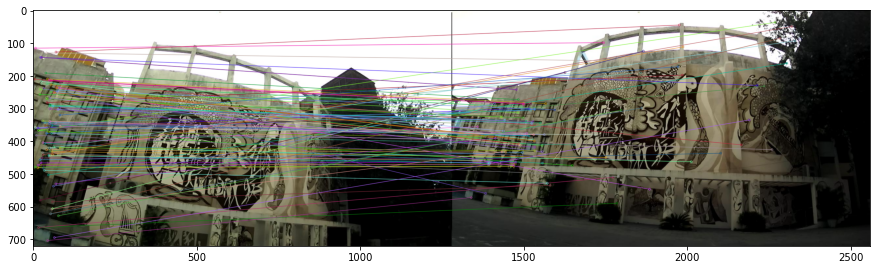

In [105]:
# Feature detection
%matplotlib inline
sift = cv2.SIFT_create()

key_1, desc_1 = sift.detectAndCompute(img1, None)
key_2, desc_2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(desc_1, desc_2)
maches = sorted(matches, key = lambda x: x.distance)
img3 = cv2.drawMatches(img1, key_1, img2, key_2, matches[:100], img2, flags=2)
fig = plt.figure(figsize=(15,25))
plt.imshow(img3)

In [106]:
p1 = np.array([(x.pt) for x in key_1], dtype=int)
p2 = np.array([(x.pt) for x in key_2], dtype=int)

In [107]:
matches_idx = np.array([(m.queryIdx, m.trainIdx)for m in matches])

In [108]:
p1 = p1[matches_idx[:,0]]
p2 = p2[matches_idx[:,1]]

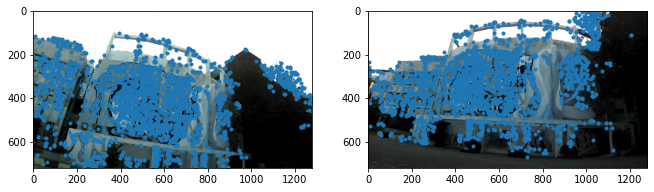

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,15))
ax[0].imshow(img1[:,:,::-1])
ax[0].plot(p1[:,0], p1[:,1], '.')
ax[1].imshow(img2[:,:,::-1])
ax[1].plot(p2[:,0], p2[:,1], '.')

In [110]:
p = 0.99
e = 0.2
s = 10

In [111]:
T = int(np.log(1-p)/np.log(1-((1-e)**s)))

In [112]:
T

40

In [113]:
F, bp, error = find_F(p2, p1, T, s)

In [114]:
bp1 = bp[1].copy()
bp2 = bp[0].copy()
bp1_h = np.hstack((bp1, np.ones((bp1.shape[0],1))))
bp2_h = np.hstack((bp2, np.ones((bp2.shape[0],1))))


In [115]:
bp1.shape

(10, 2)

In [116]:
print('F estimated: ', F)

F estimated:  [[-1.62026440e-07  2.29880422e-06 -1.01800570e-03]
 [ 8.12267743e-07  1.31319578e-06 -1.01957227e-03]
 [-3.22889189e-04 -1.76886635e-03  9.99997345e-01]]


#### Manual

In [117]:
p1 = np.array([[381, 402],
             [452, 497],
             [671, 538],
             [501, 254],
             [506, 381],
             [474, 440],
             [471, 537],
             [498, 364],
             [706, 319],
             [635, 367],
             [378, 126],
             [505, 135],[623,165],[719, 197],[801, 242]])


p2 = np.array([[390, 346],
             [439, 412],
             [651, 417],
             [477, 194],
             [482, 300],
             [456, 359],
             [454, 444],
             [475, 287],
             [686, 185],
             [606, 253],
             [400, 128],
             [487, 94 ],
             [594, 78],
             [701, 67],
             [821,  76]])

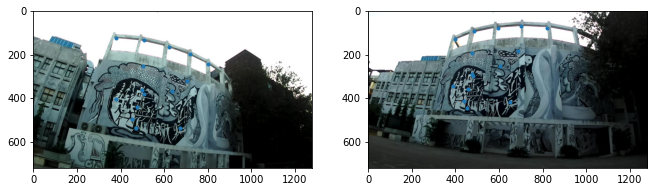

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,15))
ax[0].imshow(img1[:,:,::-1])
ax[0].plot(p1[:,0], p1[:,1], '.')
ax[1].imshow(img2[:,:,::-1])
ax[1].plot(p2[:,0], p2[:,1], '.')

In [119]:
bp1 = p1.copy()
bp2 = p2.copy()

In [120]:
F = create_F(p2, p1)

In [121]:
F


array([[-1.91691506e-06, -1.83358358e-06,  2.98619595e-04],
       [ 2.73067323e-07, -3.72769534e-07, -1.24716622e-03],
       [ 2.81705099e-03,  2.39927035e-03, -9.99992332e-01]])

### Calculation

In [122]:
bp1_h = np.hstack((bp1, np.ones((bp1.shape[0],1))))
bp2_h = np.hstack((bp2, np.ones((bp2.shape[0],1))))

In [123]:
# epipolar lines calculation
epi_line2 =  F @ bp1_h.T
epi_line1 = F.T @ bp2_h.T

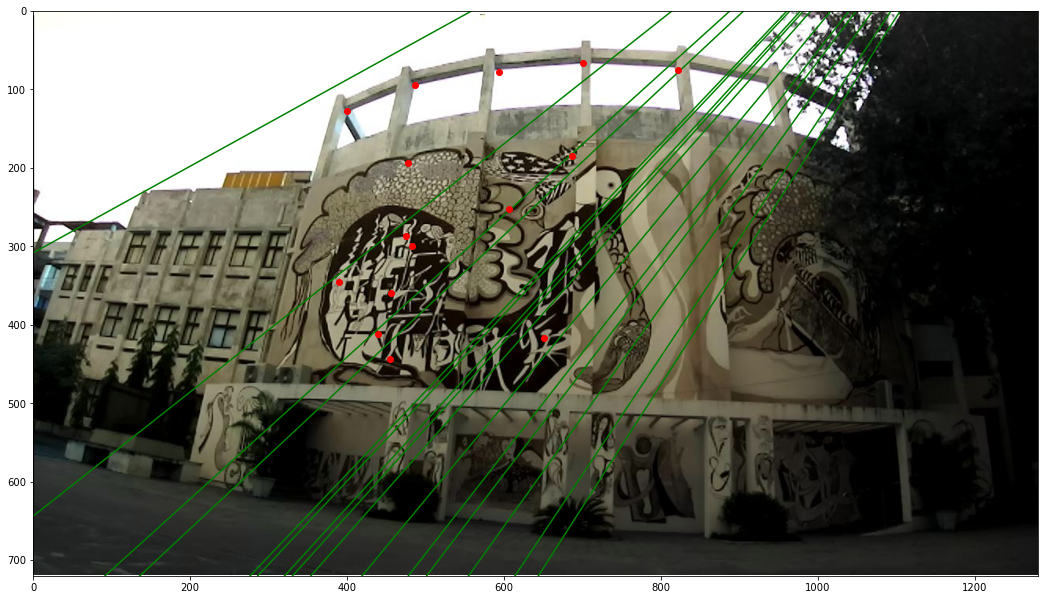

In [124]:
fig = plt.figure(figsize=(18, 16))
imgplot = plt.imshow(img2)
r,c, _ = img2.shape

plt.xlim(0,c)
plt.ylim(0,r)
x = np.linspace(-c,c,100)
for l in epi_line2.T:
    y = -(l[0]*x+l[2])/l[1]
    plt.plot(x,y,'-g')
plt.plot(bp2_h[:,0], bp2_h[:,1], 'ro')
plt.gca().invert_yaxis()
plt.show()

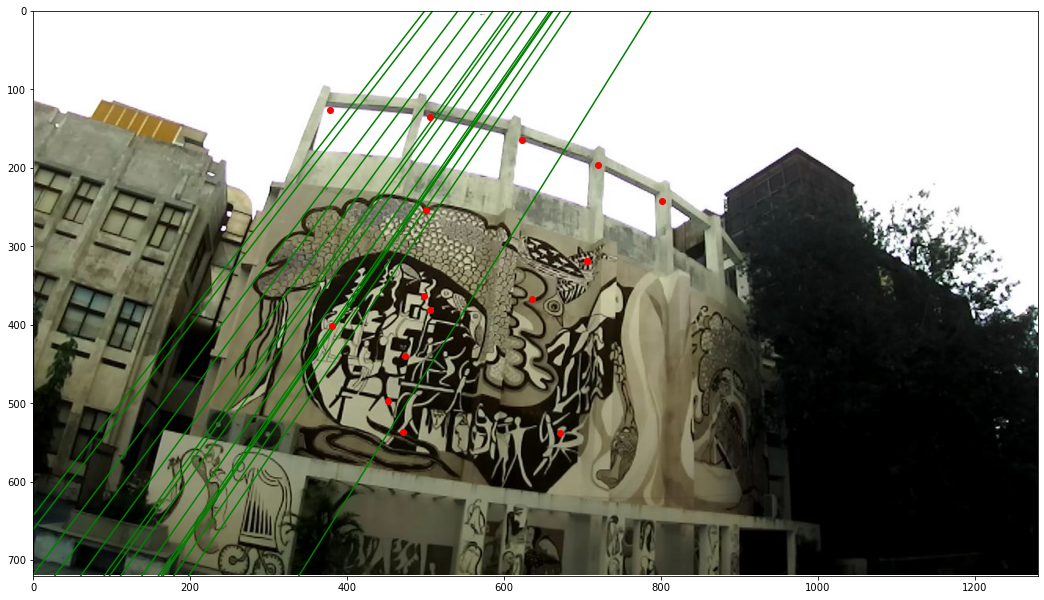

In [125]:
fig = plt.figure(figsize=(18, 16))
imgplot = plt.imshow(img1)
r,c, _ = img1.shape

plt.xlim(0,c)
plt.ylim(0,r)
x = np.linspace(-c,c,100)
for l in epi_line1.T:
    y = -(l[0]*x+l[2])/l[1]
    plt.plot(x,y,'-g')
plt.plot(bp1_h[:,0], bp1_h[:,1], 'ro')
plt.gca().invert_yaxis()
plt.show()

**Provide a clear explanation on your approach for both this task and the next**

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

In [126]:
# e2 = null(F.T), e1 = null(F)

U, D, Vh = np.linalg.svd(F)
e1 = Vh[-1,:]
e1 /= e1[2]

U, D, Vh = np.linalg.svd(F.T)
e2 = Vh[-1,:]
e2 /= e2[2]

print('e1 = ', e1)
print('e2 = ', e2)

e1 =  [ 1.97332356e+03 -1.90014467e+03  1.00000000e+00]
e2 =  [ 1.40321750e+03 -4.65827311e+02  1.00000000e+00]


In [129]:
np.isclose(e1.reshape(1,-1) @ epi_line1, 0)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])

In [130]:
np.isclose(e2.reshape(1,-1) @ epi_line2, 0)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])

All epi lines intersect at epi pole as it satisfies all the lines
### Mathematical solution
[q2_sol](./q2_sol.pdf)

____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

### Initial Calculations
Please read this before proceding
[q3_sol](./q3_sol.pdf)

In [133]:
A_I = np.array([753, 266])

In [134]:
# camera co-ords in world frame
Z_c = 721.53 * 1.65 / (172.85 - 266)
X_c = (-609.55 + 753) * Z_c / 721.53
Y_c = -1.65

In [135]:
# R_C^W = R_wc
R_WC = np.eye(3)
t_WC = -np.array([X_c, Y_c, Z_c]).reshape(3,1)
K = np.array([[7.2153e+02,0,6.0955e+02],[0,7.2153e+02,1.7285e+02],[0,0,1]])

In [136]:
K, t_WC

(array([[721.53,   0.  , 609.55],
        [  0.  , 721.53, 172.85],
        [  0.  ,   0.  ,   1.  ]]),
 array([[ 2.54098229],
        [ 1.65      ],
        [12.78072464]]))

In [137]:
P = K @ np.hstack((R_WC, t_WC))

In [138]:
P

array([[7.21530000e+02, 0.00000000e+00, 6.09550000e+02, 9.62388565e+03],
       [0.00000000e+00, 7.21530000e+02, 1.72850000e+02, 3.39967275e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.27807246e+01]])

In [139]:
# car dims
h = 1.38
w = 1.51
l = 4.1

In [140]:
car_cords = np.array([
    [0,0,0],
    [w,0,0],
    [w,-h,0],
    [0,-h,0],
    [0,0,-l],
    [w,0,-l],
    [w,-h,-l],
    [w,-h, 0]
])

In [141]:
car_cords = np.vstack((car_cords.T, np.ones((1,8))))

In [142]:
car_cords

array([[ 0.  ,  1.51,  1.51,  0.  ,  0.  ,  1.51,  1.51,  1.51],
       [ 0.  ,  0.  , -1.38, -1.38,  0.  ,  0.  , -1.38, -1.38],
       [ 0.  ,  0.  ,  0.  ,  0.  , -4.1 , -4.1 , -4.1 ,  0.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ]])

In [143]:
image_camera_cords = P @ car_cords

In [144]:
image_camera_cords[0] /= image_camera_cords[2]
image_camera_cords[1] /= image_camera_cords[2]
image_camera_cords = image_camera_cords[:2]
ic = image_camera_cords.T

In [177]:
img = mpimg.imread('q3/image.png')

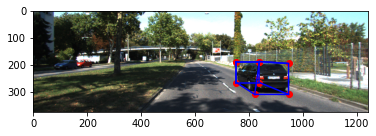

In [186]:
plt.imshow(img)
plt.plot(ic[:,0], ic[:,1], 'ro')
plt.plot(ic[:4,0], ic[:4,1], '-b')
plt.plot(ic[np.array([0,3]),0], ic[np.array([0,3]),1], '-b')
plt.plot(ic[np.array([0,3]),0], ic[np.array([0,3]),1], '-b')
plt.plot(ic[np.array([3,7]),0], ic[np.array([3,7]),1], '-b')
plt.plot(ic[np.array([2,6]),0], ic[np.array([2,6]),1], '-b')
plt.plot(ic[np.array([1,5]),0], ic[np.array([1,5]),1], '-b')
plt.plot(ic[np.array([0,4]),0], ic[np.array([0,4]),1], '-b')
plt.plot(ic[np.array([7,4]),0], ic[np.array([7,4]),1], '-b')
plt.plot(ic[4:,0], ic[4:,1], '-b')

 Mid point of rear vehicles = $\frac{((0,0,-4.1) + (1.51, 0, -4.1))}{2}$

In [187]:
mp = (np.array([0,0,-4.1]) + np.array([1.51,0,-4.1])) / 2
camera = np.array([X_c, Y_c, Z_c])
print(camera, mp)

[ -2.54098229  -1.65       -12.78072464] [ 0.755  0.    -4.1  ]


In [188]:
# t_c^mp = t_cmp
t_cmp = camera - mp

In [189]:
print("Translation vector: ", t_cmp)

Translation vector:  [-3.29598229 -1.65       -8.68072464]
